# **Retail Products Classification : Classification of retail products by image and description**

Goal of this notebook is to build a deep learning model to predict the category of retail products based on their image and description.
The dataset consits of 48000 retail products from 21 different categories with coloured images (100x100) and their description. The data is split into 42000 training samples and 6000+ test samples [[1]](https://arxiv.org/abs/2103.13864). Because this notebook is part of the Kaggle Competition [[2]](https://www.kaggle.com/c/retail-products-classification/) it will be trained on  42000 samples and later the 6000+ test samples will be used for rating the algorithm with a Mean F1-Score which will determine the place in the Kaggle leaderboard.

This notebook is split into two parts. In the first part the categories get predicted by using text and image classification. In the second part only text classification was used.

[1] A Retail Product Categorisation Dataset. Febin Sebastian Elayanithottathil, Janis Keuper (2021). https://arxiv.org/abs/2103.13864
<br>
[2] Kaggle Competition: Retail Products Classification (2021). https://www.kaggle.com/c/retail-products-classification/

## Loading Data from Google-Drive

Because this notebook was developed on Google Colab the dataset has to be either downloaded from Google Drive or Kaggle. The first option was used in this case.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#the dataset was downloaded as .zip from Kaggle and then uploaded to Google Drive
!ls "/content/drive/My Drive/Colab Notebooks/retail-products-classification.zip"

#this tokenizer will be later needed for preprocessing the data for BERT
!ls "/content/drive/My Drive/Colab Notebooks/tokenization.py"

In [ ]:
# unzipping all the train/test image folders and both the train.csv and test.csv
!unzip drive/"My Drive"/"Colab Notebooks"/retail-products-classification.zip

## Importing all necessary Librarys

In [ ]:
!pip install keras_metrics #will be needed to evaluate the trained model later

In [ ]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import keras_metrics
import plotly.express as px
from wordcloud import WordCloud
import gensim
import gensim.downloader as api
from gensim.parsing.porter import PorterStemmer
from tqdm import tqdm
from keras.applications import densenet
import re
import gc
import fileinput
import string
import zipfile
import datetime
import sys
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))

## List of all Product Categories

The following list includes all possible 21 categories of the different retail products.

In [ ]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

## Read the train.csv file

The test.csv consists of the columns: ImgID, title, description and categories. The ImageID can be later used to connect the text and image data for each sample.

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


## Distribution of samples in each categories

Shows that all the samples are eqaully distributed over all 21 categories which is very important for training the algorithm.

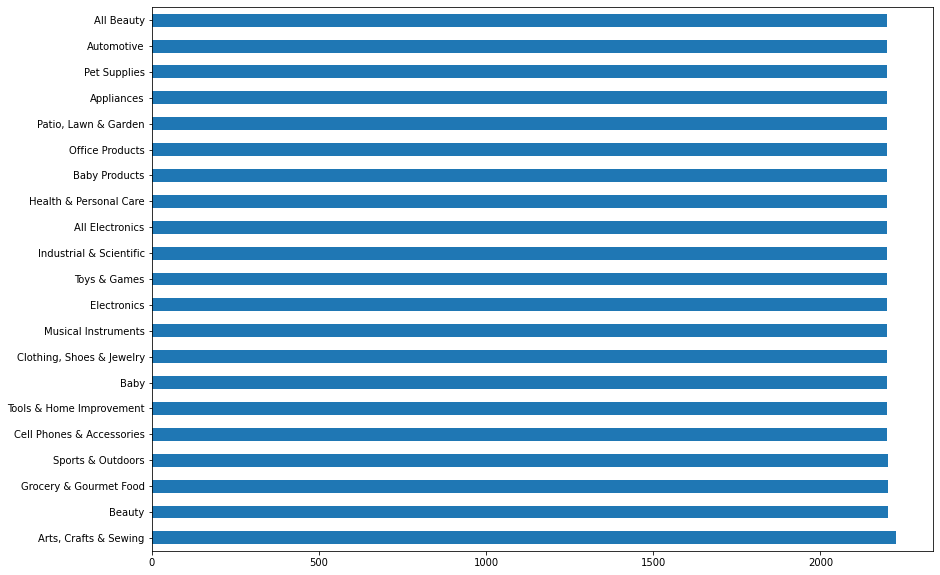

In [ ]:
data['categories'].value_counts().plot(kind='barh', figsize=(14, 10));

## Most frequent words in the description e.g. Electronics and Beauty products

Shows the most frequent words in the examples categories "Electronics" and "Beauty".

Most frequent words in Electronics


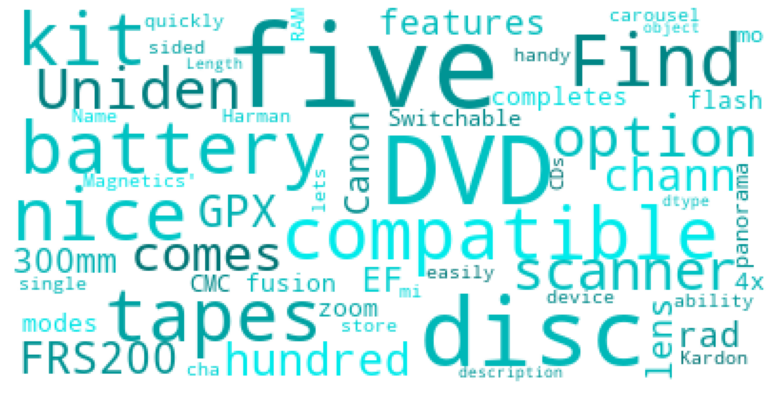

In [ ]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["categories"]=="Electronics"].description))
print(wordcloud)
fig = plt.figure(figsize=(14,7))
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3))
plt.axis('off')
print("Most frequent words in Electronics")
plt.show()

Most frequent words in Beauty


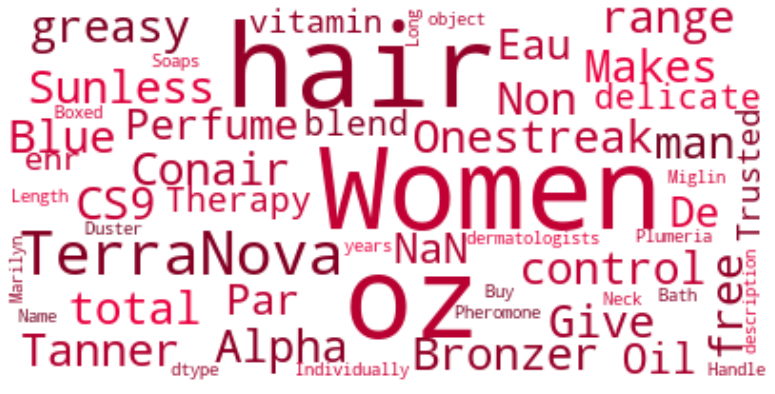

In [ ]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["categories"]=="Beauty"].description))
print(wordcloud)
fig = plt.figure(figsize=(14,7))
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
print("Most frequent words in Beauty")
plt.show()

## Distribution of characters in the description

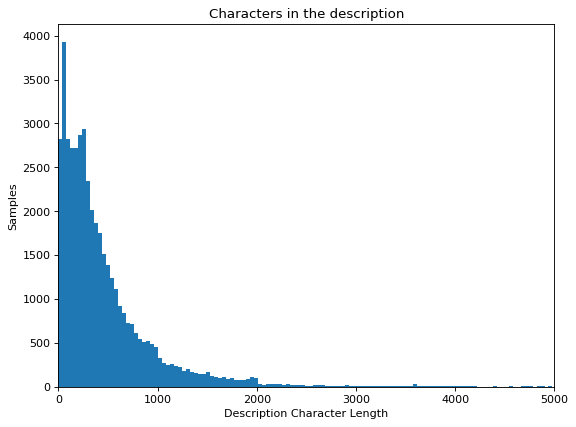

In [ ]:
from matplotlib.pyplot import figure

char_len=data['description'].str.len()
figure(figsize=(8, 6), dpi=80)
plt.hist(char_len, bins=500)
plt.ylabel('Samples')
plt.xlabel('Description Character Length')
plt.title('Characters in the description')
plt.xlim([0, 5000])
plt.show()

## Distribution of words in the description

The figure shows that lots of descriptions consist of few words and it should be looked into if this samples decrease the accuracy of the alogorithm.

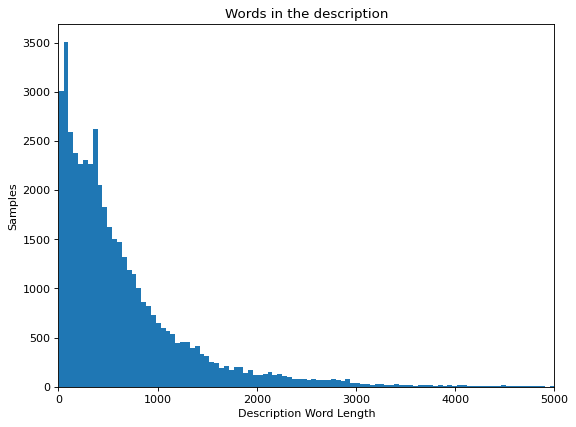

In [ ]:
word_len=data['description'].str.split().map(lambda x: len(str(x)))
figure(figsize=(8, 6), dpi=80)
plt.hist(word_len, bins=500)
plt.ylabel('Samples')
plt.xlabel('Description Word Length');
plt.title('Words in the description')
plt.xlim([0, 5000])
plt.show()

## Distribution of word density in the description

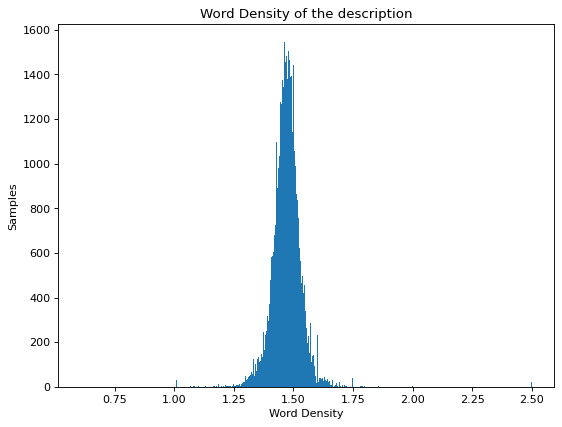

In [ ]:
word_density = word_len / (char_len + 1)
figure(figsize=(8, 6), dpi=80)
plt.hist(word_density, bins=500)
plt.ylabel('Samples')
plt.xlabel('Word Density');
plt.title('Word Density of the description')
plt.show()

## Load pictures (.jpg) and creating training data

The image size of 80 x 80 achieved the highest accuracy when training the images seperatly from the text.

In [ ]:
train_images_path = 'train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = len(CATEGORIES)

In [ ]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print("Length of downloaded files: ", len(downloaded_files))

Length of downloaded files:  42000


In [ ]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=IMG_SIZE)
    img_array = img_to_array(image)
    return img_array

## Tokenization

In the beginning the function get_token() was used to remove stopwords and put all the text samples in seperate tokens. This was used for Fasttext and GloVe but not for BERT.

The accuracy while training BERT with removed stopwords and lemmatized words, was lower as running BERT with the full corpus. BERT already uses Byte-Pair Encoding (BPE) thats why lemmatization is not necessary in this case. 
When it comes to the stopwords it looks like BERT learned that they are not useful and dumps redundant attention weights on them [[3]](https://arxiv.org/abs/1904.07531). Thats why the function get_token() won't be used for preprocessing the text.

**-> The function get_token() can be found in the attachment part of this notebook**

[3] Understanding the Behaviors of BERT in Ranking. Yifan Qiao, Chenyan Xiong, Zhenghao Liu, Zhiyuan Liu (2019). https://arxiv.org/abs/1904.07531

## Normalize the images

The images have to get normalized before they can be trained. Firstly they get divided by 255 so every pixel has a value between 0 and 1. After that the data gets centered by using substraction.

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

## Connect images and descriptions

In the following part the text data and images get connected by their ImageID. Also all categories get indexed. It's important that the indexs match the ones on Kaggle. If the models would be trained on different indexed categories it would result in a low F1-Score when submitting the predictions. This is what happend in the beginning. More about that error in the BERT part.

In [ ]:
corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = str(title) + ' ' + str(description)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
images = preprocess_input(images)

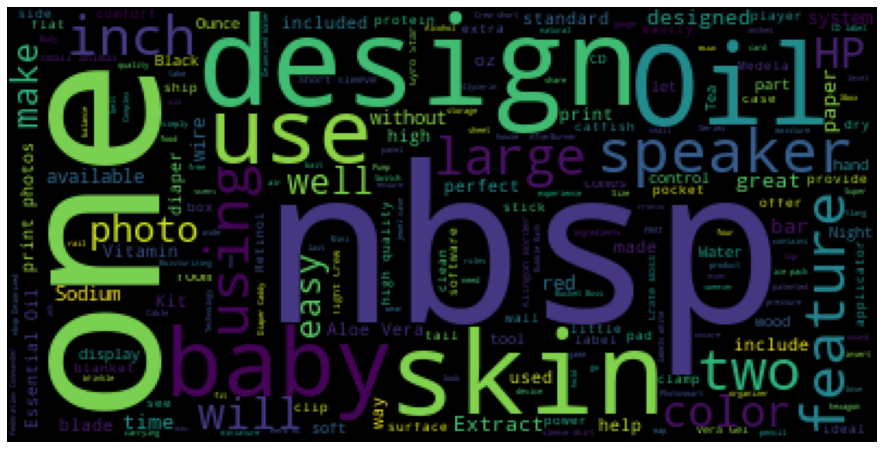

In [ ]:
plt.figure(figsize=(16,8))
text = [s for s in corpus]
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 100
                         ).generate(" ".join(text[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Remove identical images

The dataset includes some identical images that can be easily removed. The problem is that removing this images will lead to less descriptions which could be used for training BERT. After  running the model with and without the identical images, the score was a bit higher with all the images. It looked like the accuracy improved becasue BERT had more trainsamples.

**-> The code can be found in the attachment part of this notebook**

## Get low frequency words

After analysing the distribution of characters in the description it was clear that the dataset includes some small descriptions that consists of one ore two words. Thats why the model was firstly trained with all descriptions that include more than two words. All data samples with smaller descriptiosn were deleted.

This part was later removed because of BERT, which works better the more data it gets, no matter how many words the descritpion has 
<br>

**-> The code can be found in the attachment part of this notebook**

## Fasttext and GloVe

Before using BERT for text classification the description was trained on pretrained word embadddings. Fasttext and GloVe are widely used and often outperform other pretrained word embaddings [[4]](https://www.researchgate.net/publication/341284216_Comparative_Analysis_of_Word_Embeddings_for_Capturing_Word_Similarities). GloVe got an val_accuracy of ~0,75 while Fasttext could only archieve ~0,72. Because BERT could achive a higher accuaracy both word embeddings won't be used.

**-> The code for GloVe and Fasttext can be found in the attachment part of this notebook**

[4] Comparative Analysis of Word Embeddings for Capturing Word Similarities. Martina Toshevska, Frosina Stojanovska and Jovan Kalajdjieski (2020). https://www.researchgate.net/publication/341284216_Comparative_Analysis_of_Word_Embeddings_for_Capturing_Word_Similarities

## BERT

For the final text classification a pretrained BERT-Model was used. It was downloaded from Tensorflow-Hub and preprocessed with an tokenizer.py file. The original tokenizer.py file for BERT didn't work with the newest Tensorflow Version (2.5.0). So it had to be edited and uploaded to Google Colab. After the edit the errors were fixed.

The model was firstly trained alone without the image classification so it could be better finetuned. The finetuning was mostly based on a scientific paper [[5]](https://arxiv.org/abs/1905.05583). It suggested different learning rates and different sizes of BERT-Layers. While the algorithm in the paper could archieve a higher score with a BERT-Large Model it wasn't the case for this classification problem. In this case the BERT-Base Model managed to get the higher score in the Kaggle submission. But this was the main difference between the algorithm from the paper and this one. Like in the paper the best result could be archieved with a learnign rate of 2e-5 and a epoch size of 4. The text classification with BERT-Base managed to get a val_accuracy of ~0.83 without any image classification.

[5] How to Fine-Tune BERT for Text Classification?. Chi Sun, Xipeng Qiu, Yige Xu, Xuanjing Huang (2019). https://arxiv.org/abs/1905.05583

In [ ]:
!pip install sentencepiece # required for the BERT-Tokenizer file to work

In [ ]:
from shutil import copyfile
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
copyfile(src = "/content/drive/MyDrive/Colab Notebooks/tokenization.py", dst = "tokenization.py")
import tokenization
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In the beginning a function called *read_and_preprocess()* was used which resulted in a big error: The categories were random indexed and got different indices assigned than the ones on Kaggle (e.g. Electronics had the index 3 instad of 0). This is the reason why the first two kaggle submissions had a score of ~0.04. After some time the problem could be determined and fixed. The labels are now indexed the right way, in the cell "Connect images and descriptions".

**-> The function read_and_preprocess() can be found in the attachment part of this notebook**

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = LR),
              loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"   #Bert-Base
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1" #Bert-Large
bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
bert_model = build_model(bert_layer, max_len=160)

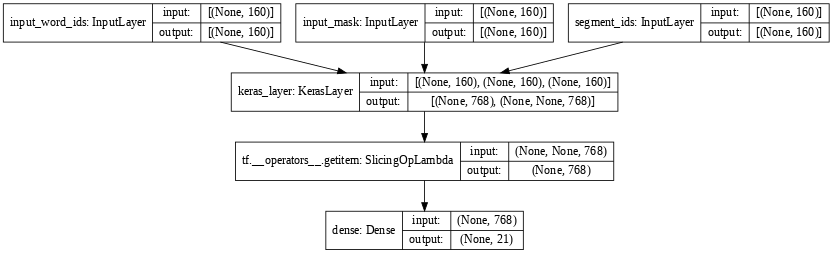

In [ ]:
tf.keras.utils.plot_model(model=bert_model, show_shapes=True, dpi=60, )

## XLNet

It's often suggested that XLNet performs better than BERT [[6]](https://arxiv.org/abs/1906.08237) but it isn't the case for this classification problem. XLNet could only archeive a val_accuracy of ~0.81 with the same hyperparamters as BERT. It won't be used for the final model.

**-> The code for XLNet be found in the attachment part of this notebook**

[6] XLNet: Generalized Autoregressive Pretraining for Language Understanding. Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le (2019). https://arxiv.org/abs/1906.08237

## Image Classification with VGG16

The image classification was firstly trained speratly from the text classification, so it can be better fine tuned. After comparing different pretrained Models like Densenet, Mobilenet, Resnet and VGG with different layers VGG16 had the best val_accuracy of ~0.51. After trying different ways and hyperparameter optimizations, the accuracy could't come near the one of BERT. The problem resolves around the categories Electronics / All Electronics and Beauty / All Beauty. Its even hard for the human eye to differentiate between electronic products and products which can be assigned to the category "All electronics". In this case the text classification has a big advantage, because the differences are more clearly in the titles and descriptions.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16(input_shape=INPUT_SHAPE,weights='imagenet', include_top=False)
x=vgg16_model.output

for layer in vgg16_model.layers[:15]:
    layer.trainable = False #not all pretrained layers should be trained

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x) # Softmax for multiclass
vgg16_model = Model(inputs=vgg16_model.input, outputs=x)

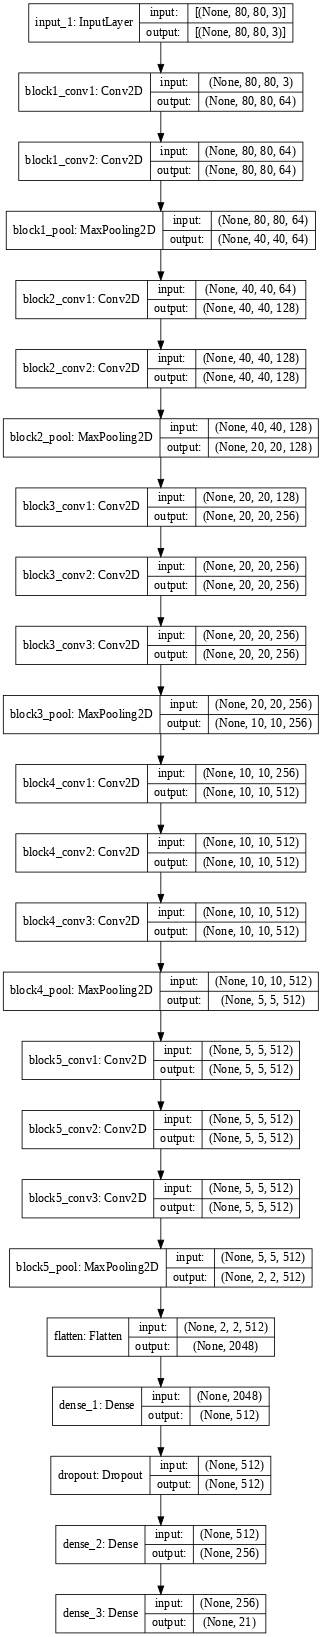

In [ ]:
tf.keras.utils.plot_model(model=vgg16_model, show_shapes=True, dpi=60, )

## Concatenate both models

After creating both text and image classification models they have to get concatenated. Using a Dropout of 0.2 and a Dense Layer of 200 before the output layer, resulted in the best val_accuracy. The final model is shown in the figure underneath.

In [ ]:
merged = tf.keras.layers.Concatenate()([bert_model.output, vgg16_model.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense = tf.keras.layers.Dense(200, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense)

final_model = tf.keras.Model(inputs=[vgg16_model.input, bert_model.input], outputs=output_layer)

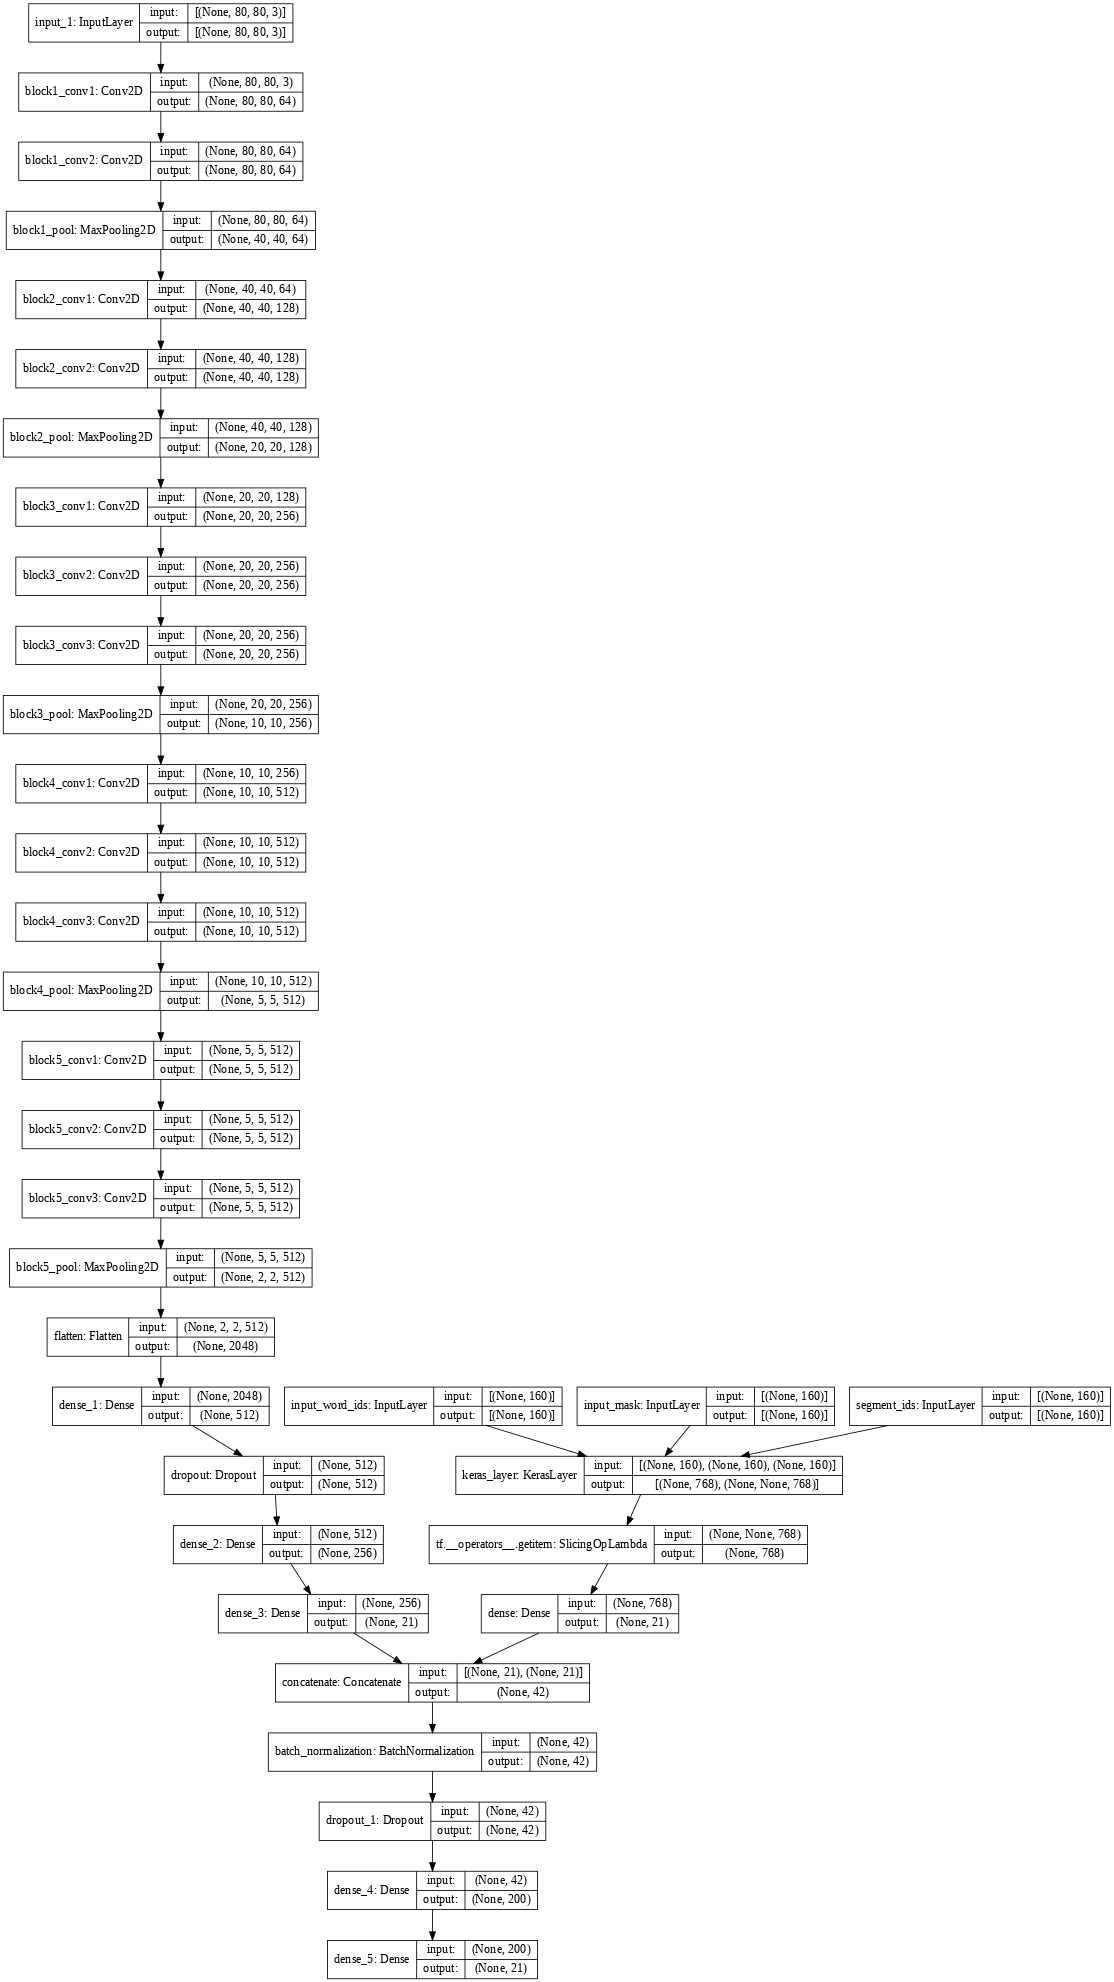

In [ ]:
tf.keras.utils.plot_model(model=final_model, show_shapes=True, dpi=60, )

## Split the data into 80% training and 20% test

All images, texts and labels were split in 80% training and 20% test data so the model can be better evaluated. Especially the validation accuracy is a important metric while training the models. It shows how good a model performs and it's almost similar to the final F1-Score of the Kaggle submission. So if a model has a lower val_accuracy than its predecessor, the steps of training it on 100% trainign data and creating the submission file can be skipped most of the time.

In [ ]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]

labels_array = np.asarray(labels)

text_train, text_test, label_train, label_test = train_test_split(corpus, labels_array, test_size=0.2, random_state=42)

#preprocessing test- and train-text with the BERT-Tokenizer
text_train = bert_encode(text_train, tokenizer, max_len=160) 
text_test = bert_encode(text_test, tokenizer, max_len=160)

## Data Augumentation

Using Data Augmentation for the images to prevent overfitting in the final model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[1]], X1i[1]

gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

## Train the model

The final learning rate of the concatenated model was 2e-5 which isn't far fetched. Both BERT and VGG16 had the best result when training seperatly on this learning rate. The same goes for the epoch size of 4.

A batch size of 16 was the highest possible on Colab.

In [ ]:
final_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 2e-5),
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

BATCH_SIZE = 16
NUM_EPOCHS = 4

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([image_train, text_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=[checkpoint], steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([image_test,text_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/4
2100/2100 [==============================] - 791s 363ms/step - loss: 2.1104 - accuracy: 0.5831 - val_loss: 1.3914 - val_accuracy: 0.7574
Epoch 2/4
2100/2100 [==============================] - 760s 362ms/step - loss: 1.1848 - accuracy: 0.8068 - val_loss: 0.8424 - val_accuracy: 0.8065
Epoch 3/4
2100/2100 [==============================] - 760s 362ms/step - loss: 0.6774 - accuracy: 0.8860 - val_loss: 0.6572 - val_accuracy: 0.8296
Epoch 4/4
2100/2100 [==============================] - 759s 362ms/step - loss: 0.4115 - accuracy: 0.9307 - val_loss: 0.6622 - val_accuracy: 0.8335


## Make predictions on validation data

After succesfully training the model the categories of the validation data can be predicted.

In [ ]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)

8400/8400 - 117s


## Plotting the predictions in a confusion matrix

The confusion matrix shows that the model works very well for the most categories and only has a few outliers. The biggest problem are the categories "Beauty" and "All Beauty" which have a big impact on the final validation accuracy of the model. It seems the model can't find the differences between both categories. While the category "Electronics" and "All Electronics" have only a few outliers it looks like all the beauty products have similar images and descriptions in both categories. The same goes for the categories "Baby" and "Baby Products".

Text(0.5, 114.0, 'Predicted label')

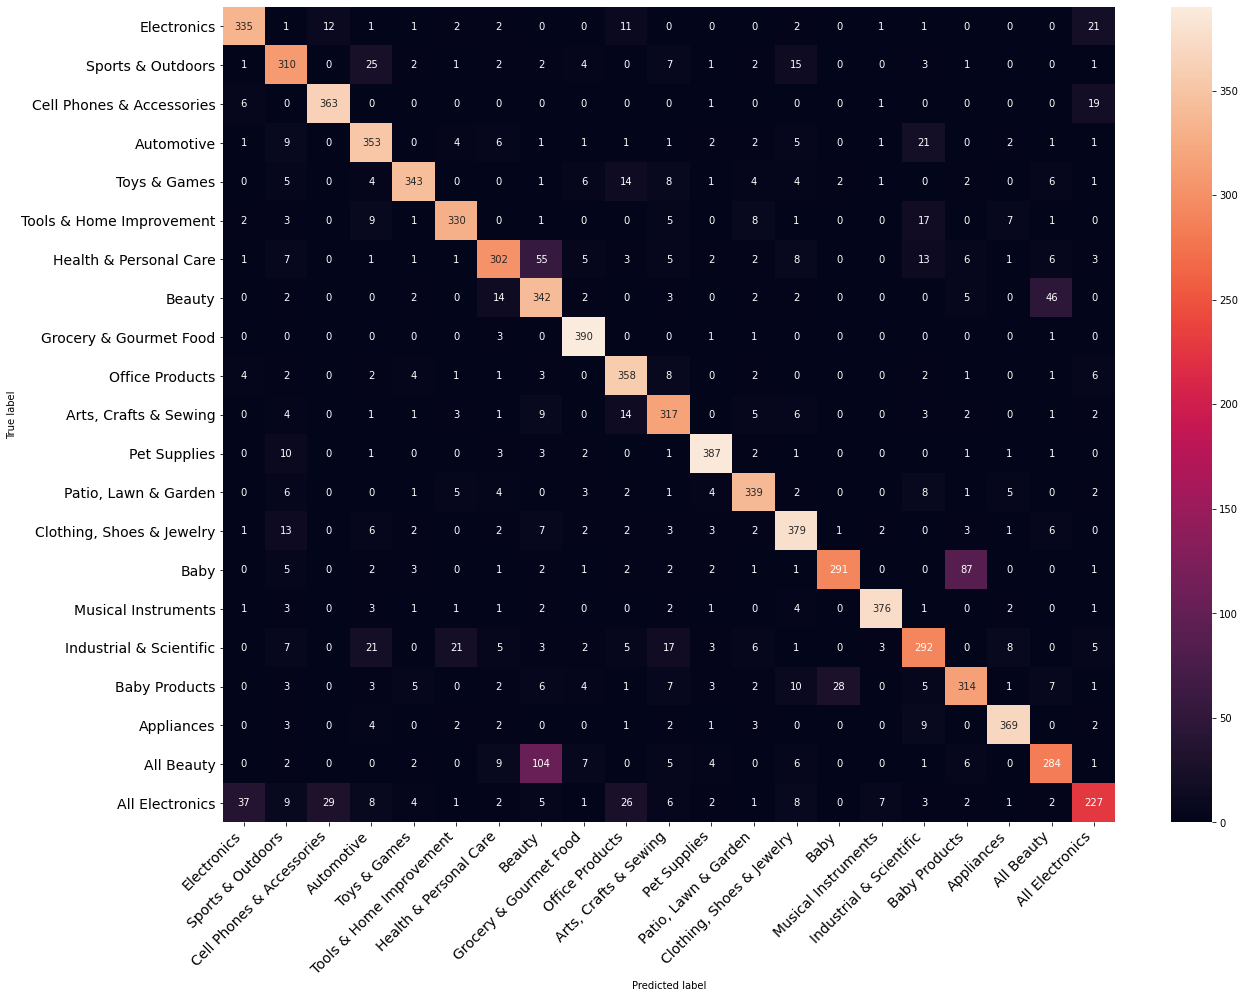

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(label_test,classes)

df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Training vs. validation accuracy

The training accuracy almost reaches 100% while the validation accuracy stagnates at around 83% after the third epoch.

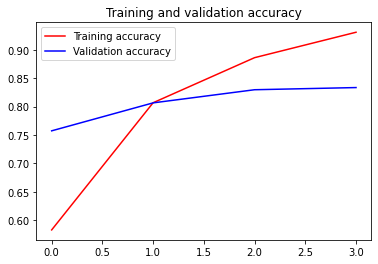

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

## Training vs. validation loss

When looking at the training loss it reaches a loss of 0.4 while the validation loss stagnates at around 0.7.

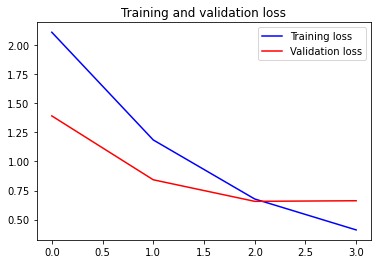

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Word frequency in "Beauty" and "All Beauty"

After looking at the confusion matrix let's look a bit more into the descriptions of the categories "Beauty" and "All Beauty".

If you compare the 20 most frequent words in "Beauty" and "All Beauty" it's getting clear that both categories almost share the same words. It seems this is the reason for most of the outliers.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import brown
import collections
nltk.download('punkt')
nltk.download('brown')

df_all_beauty = data.loc[data['categories'] == 'All Beauty']
df_all_beauty = df_all_beauty.astype(str)
df_all_beauty['test'] = df_all_beauty['title'].str.lower() + ' ' + df_all_beauty['description'].str.lower()
df_all_beauty['tokenized_sents'] = df_all_beauty['test'].apply(nltk.word_tokenize)

lists =  df_all_beauty['tokenized_sents']
words = []
for wordList in lists:
    tokens = [i for i in wordList if(len(i) > 2)]
    words += tokens

fdist = FreqDist(brown.words())
mostcommon = fdist.most_common(100)
mclist = []
for i in range(len(mostcommon)):
    mclist.append(mostcommon[i][0])
words = [w for w in words if w not in mclist]

c_all_beauty = collections.Counter(words)

In [ ]:
df_beauty = data.loc[data['categories'] == 'Beauty']
df_beauty = df_beauty.astype(str)
df_beauty['test'] = df_beauty['title'].str.lower() + ' ' + df_beauty['description'].str.lower()
df_beauty['tokenized_sents'] = df_beauty['test'].apply(nltk.word_tokenize)

lists =  df_beauty['tokenized_sents']
words = []
for wordList in lists:
    tokens = [i for i in wordList if(len(i) > 2)]
    words += tokens

fdist = FreqDist(brown.words())
mostcommon = fdist.most_common(100)
mclist = []
for i in range(len(mostcommon)):
    mclist.append(mostcommon[i][0])
words = [w for w in words if w not in mclist]

c_beauty = collections.Counter(words)

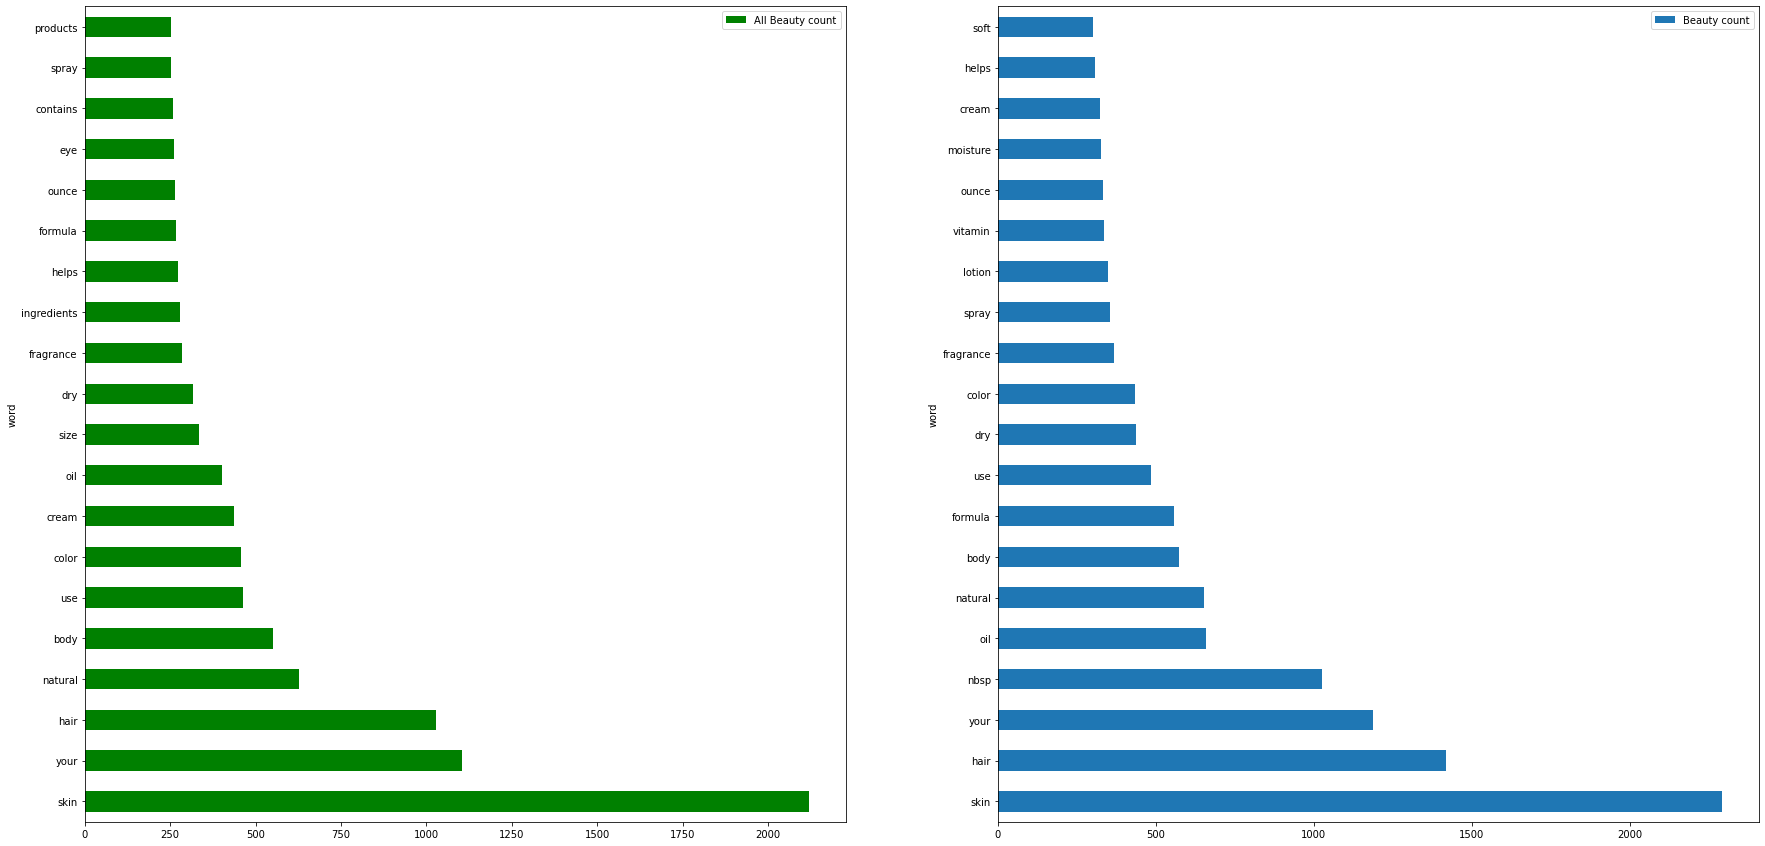

In [ ]:
all_beauty = pd.DataFrame()
all_beauty['word'] = c_all_beauty.keys()
all_beauty['All Beauty count'] = c_all_beauty.values()
all_beauty = all_beauty.sort_values(by=['All Beauty count'], ascending=False)
all_beauty = all_beauty.head(20)

beauty = pd.DataFrame()
beauty['word'] = c_beauty.keys()
beauty['Beauty count'] = c_beauty.values()
beauty = beauty.sort_values(by=['Beauty count'], ascending=False)
beauty = beauty.head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))

all_beauty.plot(ax=axes[0], kind='barh', x='word', y='All Beauty count', color='green')
beauty.plot(ax=axes[1], kind='barh', x='word', y='Beauty count');

## Read the test data

The following test data will be used for the Kaggle competition. The categories of this samples are not known.

In [ ]:
data_test = pd.read_csv('test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
test_images_path = 'test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

Like the training data the test images and texts have to get connected by the ImageID.

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(str(title) + ' ' + str(description))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

In [ ]:
#preprocess the test text data with the BERT-Tokenizer
text_train = bert_encode(test_corpus, tokenizer, max_len=160)

## Make predictions on test data


In [ ]:
final_model.load_weights('model.h5')

pred = final_model.predict([test_images, text_train],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 86s


## Create submission file

The predicted data was summarized in a submission file which could be uploaded to Kaggle to determine the F1-Score. The score was around 0,836.

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

# Retail Products Classification : Classification of retail products only by text classification

After the training of different image and text classifcation models, it became clear that the text classsification had the most impact on the accuracy of the final model. Running BERT alone wihtout any finetuning already achieved a val_accuracy of 0,83 and this without any image classification.

That's why I decided to focus a bit more on the text classification. In this second part of the notebook I worked with a python library called "ktrain" [[7]](https://github.com/amaiya/ktrain) which helps building, training and deploying neural networks.

[7] ktrain, Github, https://github.com/amaiya/ktrain

In [ ]:
!pip3 install -q ktrain

In [ ]:
#the corpus and all the labels can be loaded from the first part of the notebook
labelarray = np.asarray(labels) #ktrain needs the labels as a array
x_train, x_test, y_train, y_test = train_test_split(corpus, labelarray, test_size=0.2, random_state=42)

## Load pretrained model (BERT)

In the following part the model can be loaded and all the preprocessing will be done with the help of ktrain in a few steps.

All the pretrained models can be found on the website of Hugging Face [[8]](https://huggingface.co/transformers/pretrained_models.html). All it takes is to change the name of the variable "MODEL_NAME" and the pretrained model will be downloaded. This made it easy to test different models and find the best one. At the end the BERT-Base model could achive the highest accuracy.

[8] Hugging Face, Pretrained models, https://huggingface.co/transformers/pretrained_models.html

In [ ]:
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=CATEGORIES)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

## Train the model

Ktrain offers three different learning rate schedules such as the triangular policy, the 1cycle policy and SGDR. In this case the 1cycle was used. The learning rate 2.5e-5 achieved the best accuracy. The final F1-Score was around 0,871 with training on all the 42000 samples.

In [ ]:
learner.fit_onecycle(2.5e-5, 4)



begin training using onecycle policy with max lr of 2.5e-05...
Epoch 1/4
5600/5600 [==============================] - 2557s 453ms/step - loss: 1.4606 - accuracy: 0.5889 - val_loss: 0.7508 - val_accuracy: 0.7645
Epoch 2/4
5600/5600 [==============================] - 2541s 453ms/step - loss: 0.6522 - accuracy: 0.7966 - val_loss: 0.6237 - val_accuracy: 0.8146
Epoch 3/4
5600/5600 [==============================] - 2543s 453ms/step - loss: 0.4111 - accuracy: 0.8735 - val_loss: 0.5411 - val_accuracy: 0.8457
Epoch 4/4
5600/5600 [==============================] - 2543s 453ms/step - loss: 0.1815 - accuracy: 0.9476 - val_loss: 0.5303 - val_accuracy: 0.8589


## Plotting the predictions in a confusion matrix

The confusion matrix shows again that both the categories "Beauty" and "All Beauty" have the most outliers. On the second place are the categories "Baby" and "Baby Products".

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
classes_ktrain = predictor.predict(x_test)

In [ ]:
test_classes = []

for i in classes_ktrain:
  class_num = CATEGORIES.index(i)
  test_classes.append(class_num)

test_classes = np.asarray(test_classes)

Text(0.5, 114.0, 'Predicted label')

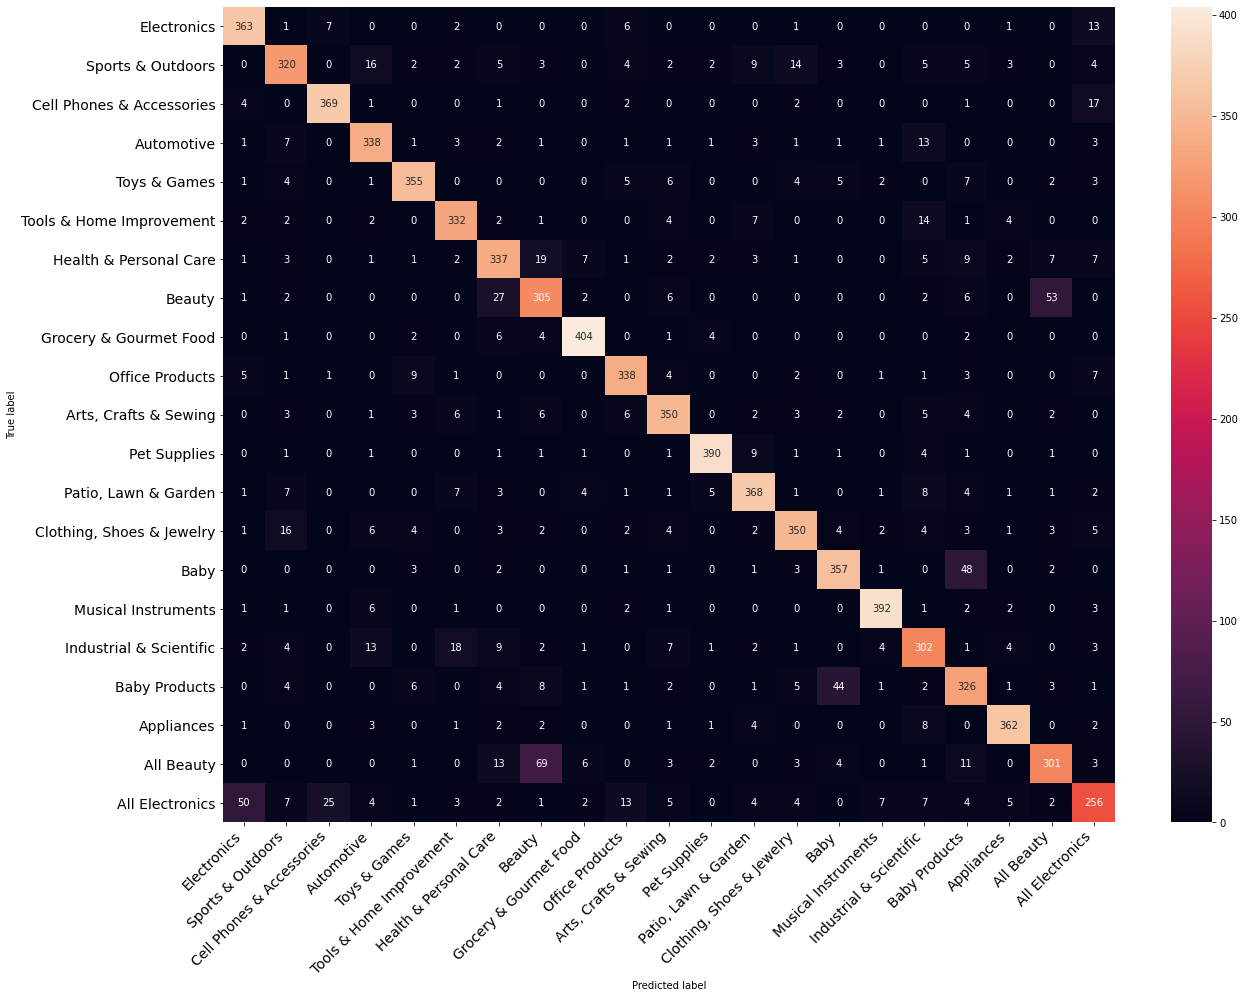

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,test_classes)

df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Data augmentation with back translation

At the end, the amount of text data was increased with the help of data augmentation. Therefor back translation was used. First the text was translated into french and after that was back translated to english. The new outcome was a slightly changed variation of the original text.

The back translation was done with the googletranslator library. Also not every description could be translated because some were to long and it would result in an error.

In [ ]:
!pip install googletrans

In [ ]:
from googletrans import Translator

corpus_back_trans = []
to_big = []

for i in corpus:
        translator = Translator()
        if(len(i) > 3000):
            to_big.append(j)
        if(len(i) < 3000):    
            translation = translator.translate(i, dest='fr')
            dummy = translator.translate(translation.text, dest='en')
            corpus_back_trans.append(dummy.text)

In [ ]:
len(corpus_back_trans)

41578

In [ ]:
#the new backtranslated corpus was concatenated with the original one and the same was done with the labels

labels_back_trans= [j for i, j in enumerate(labels) if i not in to_big]

corpus = corpus + corpus_back_trans
labels = labels + labels_back_trans

In [ ]:
len(corpus)

83578

The final training of the new corpus was done without any validation split and with all 83578 samples.

In [ ]:
labelarray = np.asarray(labels)

MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=CATEGORIES)
trn = t.preprocess_train(corpus, labelarray)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, batch_size=6)

For the training of the new corpus the learning rate of 2e-5 achieved the best F1-Score.

In [ ]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
13930/13930 [==============================] - 5919s 423ms/step - loss: 1.1287 - accuracy: 0.6800
Epoch 2/4
13930/13930 [==============================] - 5904s 423ms/step - loss: 0.4448 - accuracy: 0.8654
Epoch 3/4
13930/13930 [==============================] - 5907s 423ms/step - loss: 0.2207 - accuracy: 0.9351
Epoch 4/4
13930/13930 [==============================] - 5907s 423ms/step - loss: 0.0679 - accuracy: 0.9821


## Predict test data

After training the model it can predict the test samples.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
test_data = predictor.predict(test_corpus)

In [ ]:
test_classes = []

for i in test_data:
  class_num = CATEGORIES.index(i)
  test_classes.append(class_num)

test_classes = np.asarray(test_classes)
test_classes

## Create submission file 

The predicted test samples were summarized to a submission file. The BERT model with the back translated data achieved the highest and therefore the final F1-Score of 0,874.

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

# **Attachments**

This part includes code, that wasn't used either because it had errors or because there were better alternatives.

## Tokenization

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

def get_token(description):
   
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))

        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]

        #Lemmatize words
        lmtzr = WordNetLemmatizer()
        tokens = [lmtzr.lemmatize(t) for t in tokens]

        return tokens

## Remove identical images

In [ ]:
!pip install numpy_indexed

In [ ]:
import numpy_indexed as npi

unique = npi.unique(images)
duplicate = npi.multiplicity(images) > 1
duplicate_list = duplicate.tolist()
duplicate_list = [i for i, x in enumerate(duplicate_list) if x]

images = [j for i, j in enumerate(images) if i not in duplicate_list]
corpus = [j for i, j in enumerate(corpus) if i not in duplicate_list]
labels = [j for i, j in enumerate(labels) if i not in duplicate_list]

## Get low frequency words

In [ ]:
low_desc = []
for i,j in enumerate(corpus):
  low_desc.append(len(corpus[i]))

low_desc = [i for i, x in enumerate(low_desc) if x <= 2]

images = [j for i, j in enumerate(images) if i not in low_desc]
corpus = [j for i, j in enumerate(corpus) if i not in low_desc]
labels = [j for i, j in enumerate(labels) if i not in low_desc]

## Fasttext and GloVe

In [ ]:
#Fasttext
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)

In [ ]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

In [ ]:
#GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
with open('glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

In [ ]:
known_words = []
unknown_words = []
hits = 0
misses = 0
# Prepare embedding matrix
for word,i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        known_words.append(word)
        hits += 1
    else:
        unknown_words.append(word)
        misses += 1

In [ ]:
print("Converted %d words (%d misses)" % (hits, misses))
print("Unknown words: " + len(unknown_words))
print("Known words: " + len(known_words))

## read_and_preprocess()

In [ ]:
def read_and_preprocess():
    encoder = LabelEncoder()
    data['categories'] = encoder.fit_transform(data['categories'])
    N_CLASSES = data['categories'].nunique()
    print(f'We have {N_CLASSES} classes')
    x_train, x_val, y_train, y_val = train_test_split(corpus, data['categories'], shuffle = True, stratify = data['categories'], 
                                                      random_state = SEED, test_size = 0.2)
    return df, N_CLASSES, x_train, x_val, y_train, y_val

## XLNet

In [ ]:
!pip install -q transformers

In [ ]:
import transformers

In [ ]:
text_train, text_test, label_train, label_test = train_test_split(corpus, labels, test_size=0.2, random_state=42)

In [ ]:
from transformers import TFXLNetModel, XLNetTokenizer
from transformers import XLNetTokenizerFast
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
def create_xlnet(mname):
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 2e-5),
                  loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

In [ ]:
xlnet = create_xlnet(xlnet_model)

In [ ]:
def get_inputs(tweets, tokenizer, max_len=120):
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [ ]:
text_train, ids, segments = get_inputs(text_train, xlnet_tokenizer)
text_test, ids, segments = get_inputs(text_test, xlnet_tokenizer)